In [1]:
freq = 15

In [2]:
paciente='paciente1'

In [3]:
import codigo
from codigo import utils
from codigo import model_LSTM
from codigo import model_utils
from cg_ega.cg_ega import CG_EGA

In [4]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [7]:
len(array_Xtest)

191

In [8]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [9]:
len(array_Ytest)

191

In [10]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Pruebas Vanilla LSTM con dropout

In [11]:
model = keras.models.load_model('modelos/'+paciente+'/vanilla_dropout_balanceado.h5')

# Predicción de todo el conjunto de pruebas generales

In [12]:
len(array_Ytest)

191

6/6 [==============================] - 0s 7ms/step


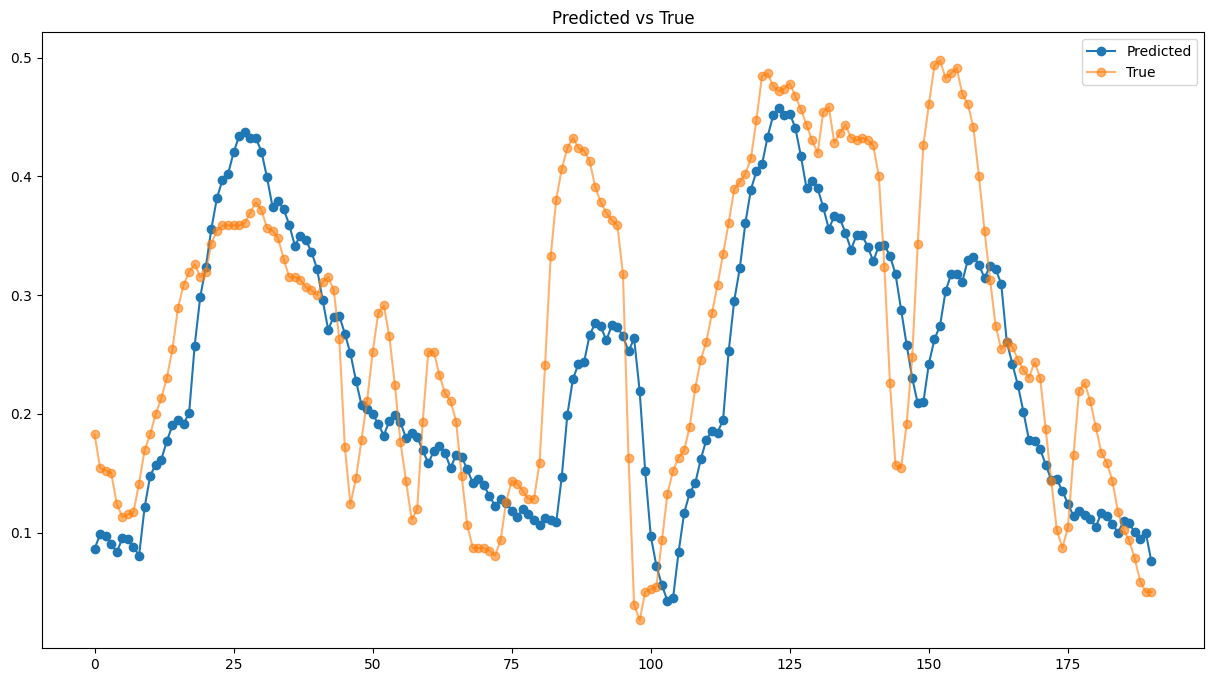

In [13]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [14]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.07046456837349509,
 'mse': 0.08932863885511336,
 'rmse': 0.007979605719707267}

In [15]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        79.693947
1        85.297775
2        84.592545
3        81.527603
4        78.398499
..             ...
186      89.551422
187      86.121399
188      83.331383
189      85.789001
190      74.847275

[191 rows x 1 columns]

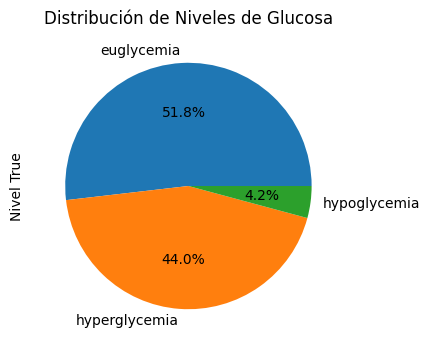

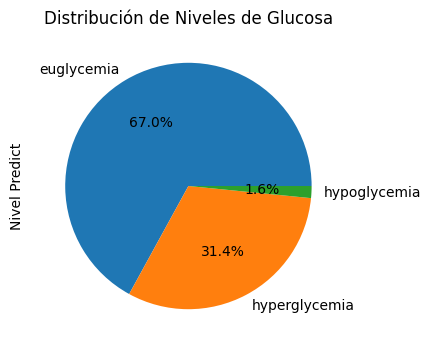

Glucose level True  Nivel True  Glucose level Predict Nivel Predict
0               124.0  euglycemia              79.693947    euglycemia
1               111.0  euglycemia              85.297775    euglycemia
2               110.0  euglycemia              84.592545    euglycemia
3               109.0  euglycemia              81.527603    euglycemia
4                97.0  euglycemia              78.398499    euglycemia

In [16]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


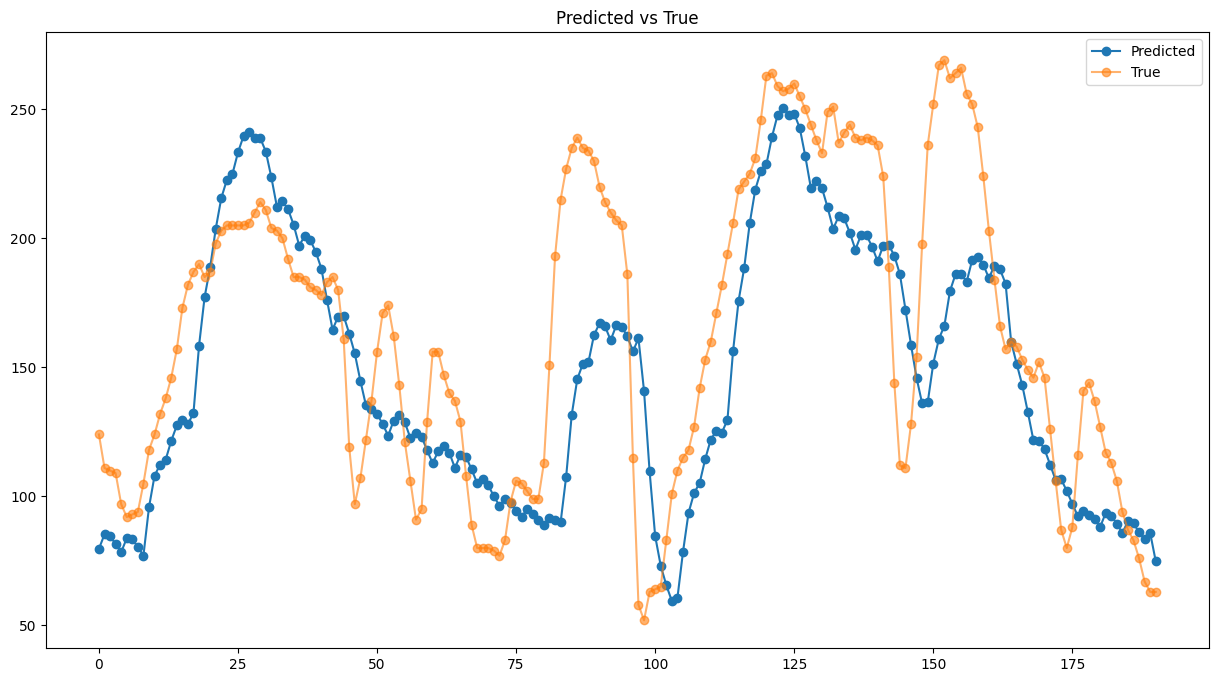

{'mae': 32.413701581705304,
 'mse': 41.09117406747378,
 'rmse': 1688.4845862434297}

In [17]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [18]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0            124.0
1            111.0
2            110.0
3            109.0
4             97.0
..             ...
186           83.0
187           76.0
188           67.0
189           63.0
190           63.0

[191 rows x 1 columns]

In [19]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true     y_pred
2023-01-01 00:00:00   124.0  79.693947
2023-01-01 00:15:00   111.0  85.297775
2023-01-01 00:30:00   110.0  84.592545
2023-01-01 00:45:00   109.0  81.527603
2023-01-01 01:00:00    97.0  78.398499
...                     ...        ...
2023-01-02 22:30:00    83.0  89.551422
2023-01-02 22:45:00    76.0  86.121399
2023-01-02 23:00:00    67.0  83.331383
2023-01-02 23:15:00    63.0  85.789001
2023-01-02 23:30:00    63.0  74.847275

[191 rows x 2 columns]

AP, BE, EP: (0.8789473684210526, 0.06842105263157895, 0.05263157894736842)


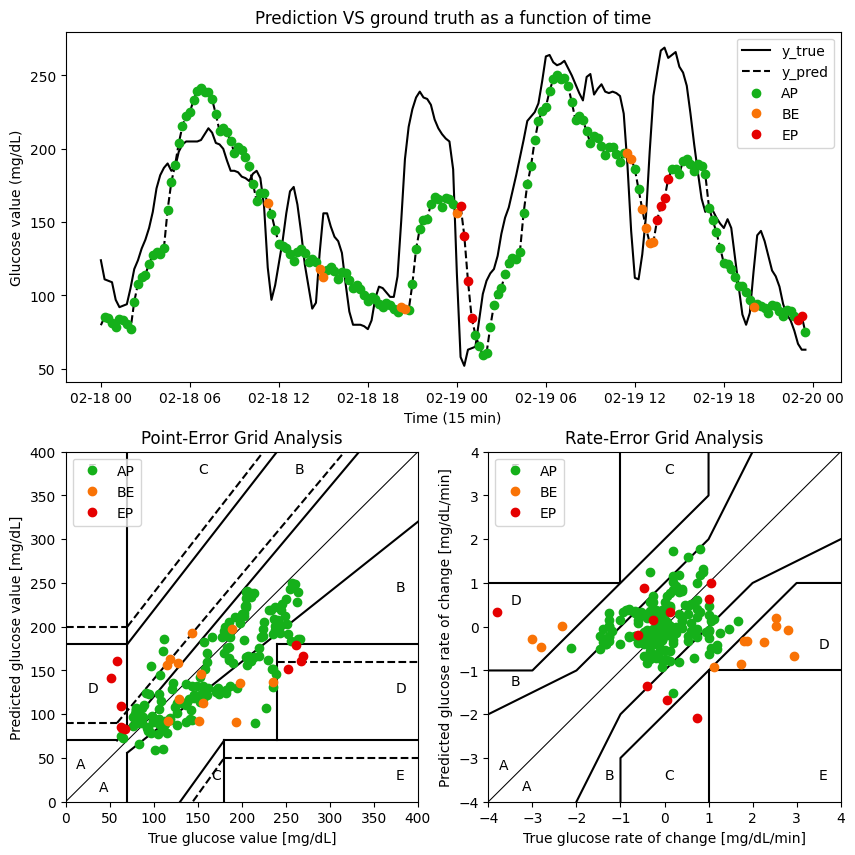

In [20]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [21]:
cg_ega.per_sample()

datetime  y_true     y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0   2023-02-18 00:00:00   124.0  79.693947       NaN       NaN    NaN   NaN   
1   2023-02-18 00:15:00   111.0  85.297775 -0.866667  0.373589     AP     B   
2   2023-02-18 00:30:00   110.0  84.592545 -0.066667 -0.047015     AP     B   
3   2023-02-18 00:45:00   109.0  81.527603 -0.066667 -0.204329     AP     B   
4   2023-02-18 01:00:00    97.0  78.398499 -0.800000 -0.208607     AP     A   
..                  ...     ...        ...       ...       ...    ...   ...   
186 2023-02-19 22:30:00    83.0  89.551422 -0.266667 -0.055652     AP     A   
187 2023-02-19 22:45:00    76.0  86.121399 -0.466667 -0.228668     AP     A   
188 2023-02-19 23:00:00    67.0  83.331383 -0.600000 -0.186001     EP     D   
189 2023-02-19 23:15:00    63.0  85.789001 -0.266667  0.163841     EP     D   
190 2023-02-19 23:30:00    63.0  74.847275  0.000000 -0.729448     AP     A   

    R_EGA  
0     NaN  
1       B  
2       A  
3       A  
4       A  
..    ...  
186     A  
187     A  
188     A  
189     A  
190     A  

[191 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [22]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [23]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 30ms/step


Glucose level Predict  Glucose level True
0               0.086291            0.182609
1               0.098473            0.154348

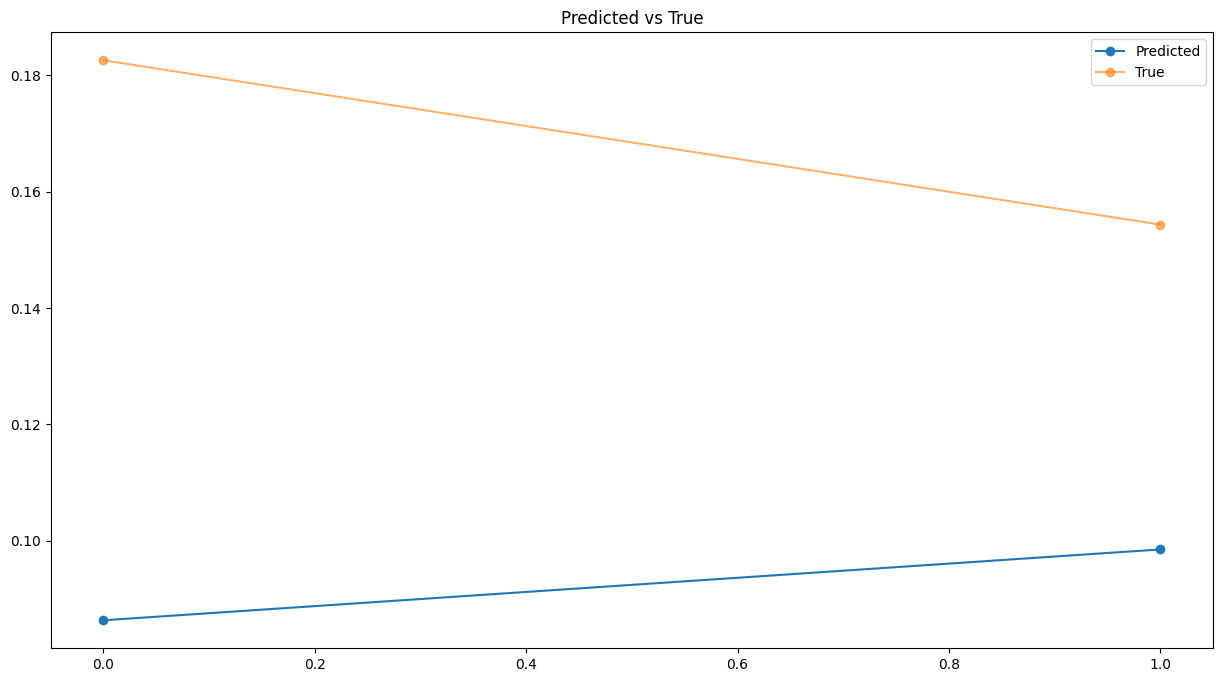

{'mae': 0.07609594904858133,
 'mse': 0.07873693130616977,
 'rmse': 0.006199504351512496}

In [24]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [25]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0              79.693954               124.0
1              85.297775               111.0

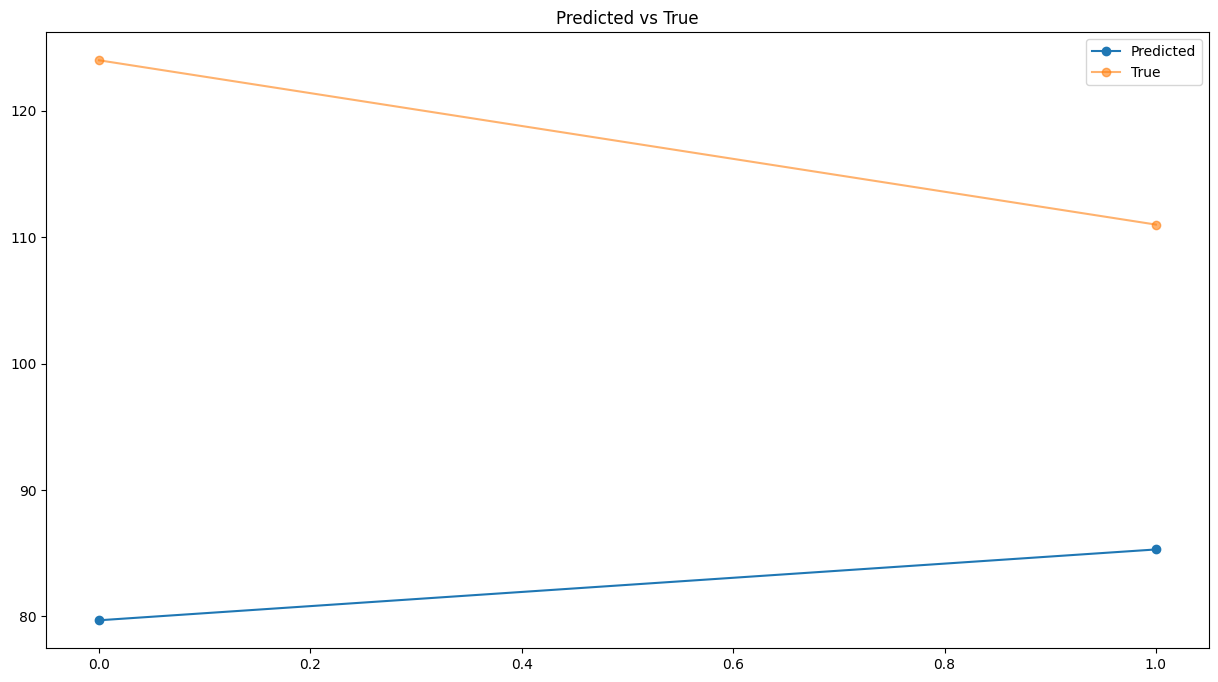

{'mae': 35.00413513183594,
 'mse': 36.21898691880719,
 'rmse': 1311.8150134247262}

In [26]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Vanilla LSTM sin dropout

In [27]:
model = keras.models.load_model('modelos/'+paciente+'/vanilla_NO_dropout_balanceado.h5')

# Predicción de todo el conjunto de pruebas generales

In [28]:
len(array_Ytest)

191

6/6 [==============================] - 0s 5ms/step


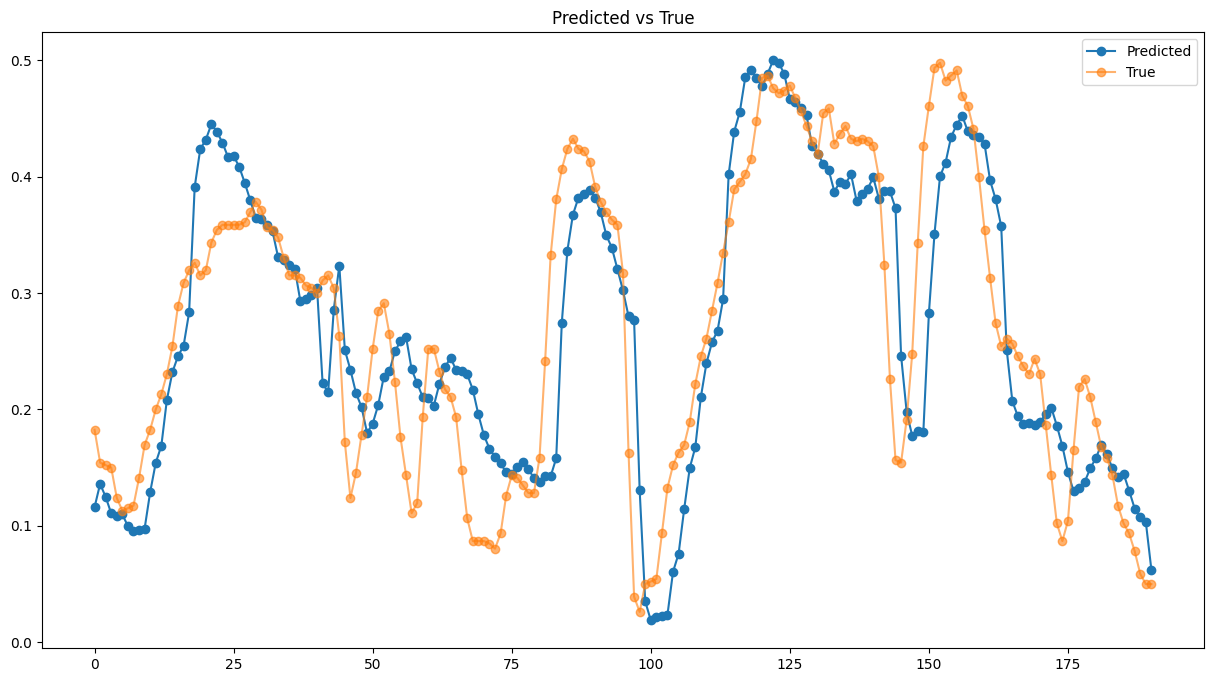

In [29]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [30]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.05324906616344719,
 'mse': 0.07019801632567285,
 'rmse': 0.0049277614960594315}

In [31]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        93.398804
1       102.601837
2        97.393333
3        90.925240
4        89.855225
..             ...
186      99.883865
187      92.839775
188      89.617508
189      87.520164
190      68.672188

[191 rows x 1 columns]

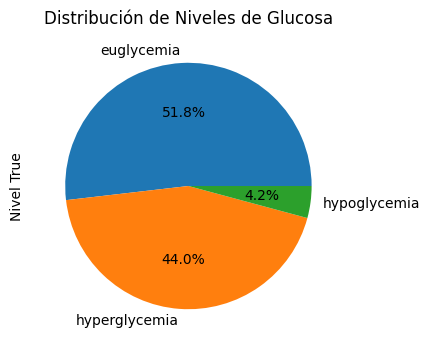

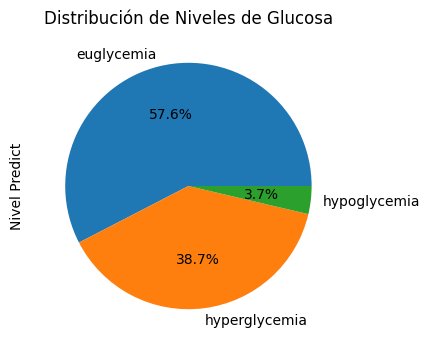

Glucose level True  Nivel True  Glucose level Predict Nivel Predict
0               124.0  euglycemia              93.398804    euglycemia
1               111.0  euglycemia             102.601837    euglycemia
2               110.0  euglycemia              97.393333    euglycemia
3               109.0  euglycemia              90.925240    euglycemia
4                97.0  euglycemia              89.855225    euglycemia

In [32]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


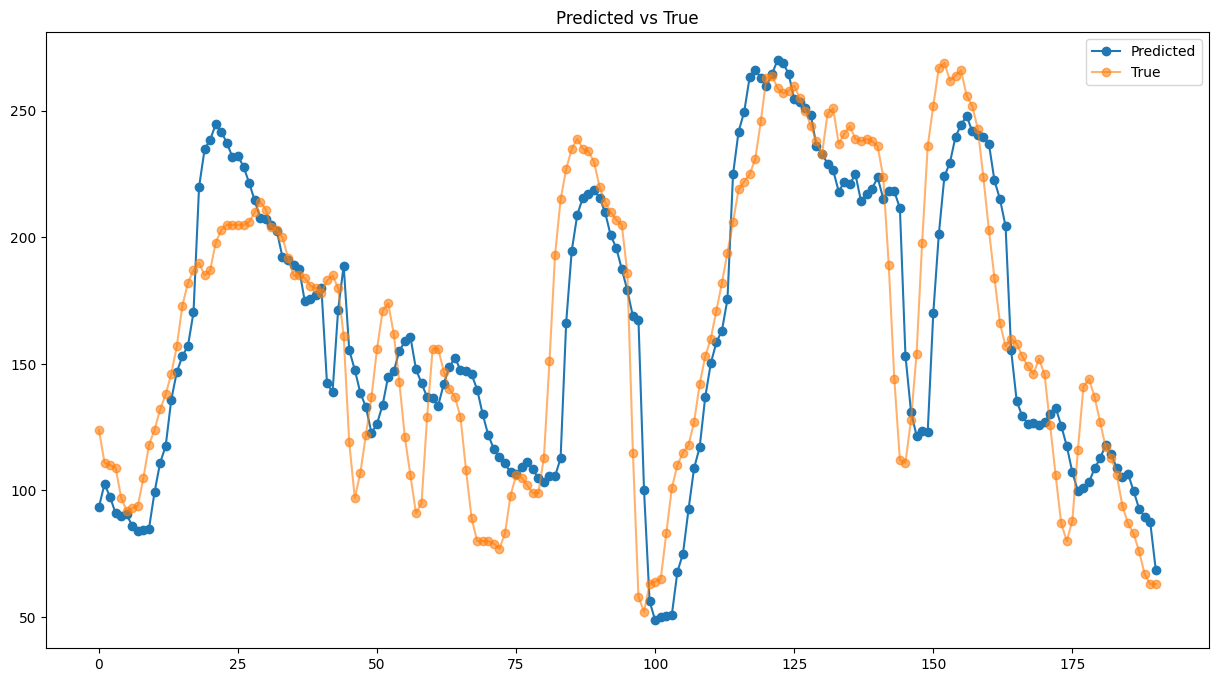

{'mae': 24.49457018787324,
 'mse': 32.291087642558466,
 'rmse': 1042.714341139392}

In [33]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [34]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0            124.0
1            111.0
2            110.0
3            109.0
4             97.0
..             ...
186           83.0
187           76.0
188           67.0
189           63.0
190           63.0

[191 rows x 1 columns]

In [35]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   124.0   93.398804
2023-01-01 00:15:00   111.0  102.601837
2023-01-01 00:30:00   110.0   97.393333
2023-01-01 00:45:00   109.0   90.925240
2023-01-01 01:00:00    97.0   89.855225
...                     ...         ...
2023-01-02 22:30:00    83.0   99.883865
2023-01-02 22:45:00    76.0   92.839775
2023-01-02 23:00:00    67.0   89.617508
2023-01-02 23:15:00    63.0   87.520164
2023-01-02 23:30:00    63.0   68.672188

[191 rows x 2 columns]

AP, BE, EP: (0.868421052631579, 0.09473684210526316, 0.03684210526315789)


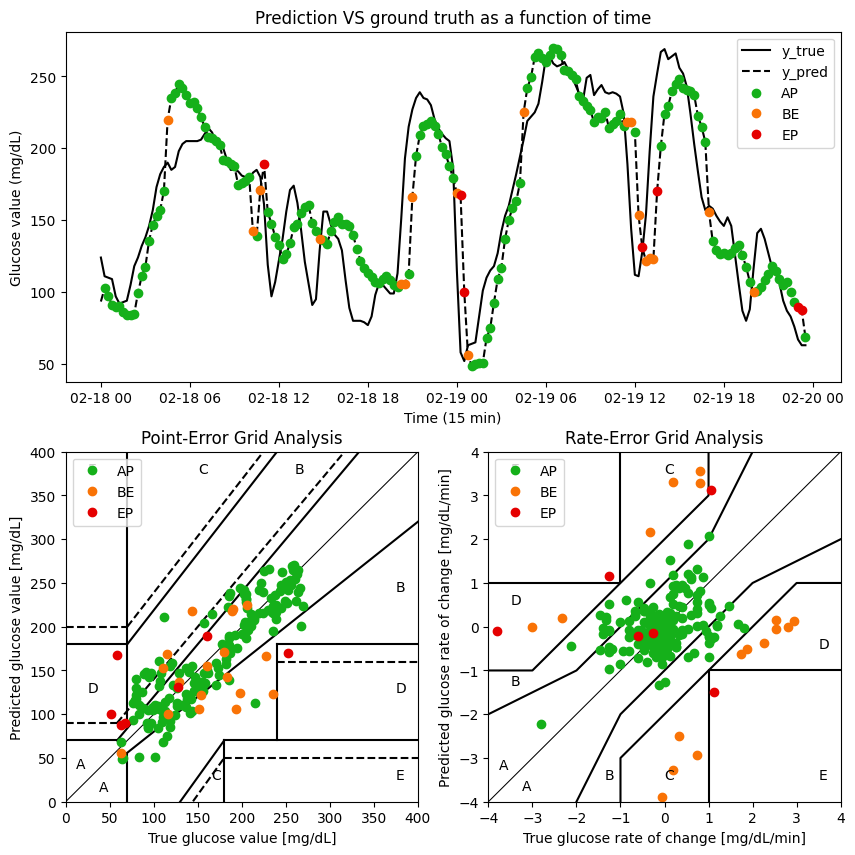

In [36]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [37]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0   2023-02-18 00:00:00   124.0   93.398804       NaN       NaN    NaN   NaN   
1   2023-02-18 00:15:00   111.0  102.601837 -0.866667  0.613536     AP     A   
2   2023-02-18 00:30:00   110.0   97.393333 -0.066667 -0.347234     AP     A   
3   2023-02-18 00:45:00   109.0   90.925240 -0.066667 -0.431206     AP     A   
4   2023-02-18 01:00:00    97.0   89.855225 -0.800000 -0.071334     AP     A   
..                  ...     ...         ...       ...       ...    ...   ...   
186 2023-02-19 22:30:00    83.0   99.883865 -0.266667 -0.453082     AP     B   
187 2023-02-19 22:45:00    76.0   92.839775 -0.466667 -0.469606     AP     B   
188 2023-02-19 23:00:00    67.0   89.617508 -0.600000 -0.214818     EP     D   
189 2023-02-19 23:15:00    63.0   87.520164 -0.266667 -0.139823     EP     D   
190 2023-02-19 23:30:00    63.0   68.672188  0.000000 -1.256532     AP     A   

    R_EGA  
0     NaN  
1       B  
2       A  
3       A  
4       A  
..    ...  
186     A  
187     A  
188     A  
189     A  
190     B  

[191 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [38]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [39]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 32ms/step


Glucose level Predict  Glucose level True
0               0.116084            0.182609
1               0.136091            0.154348

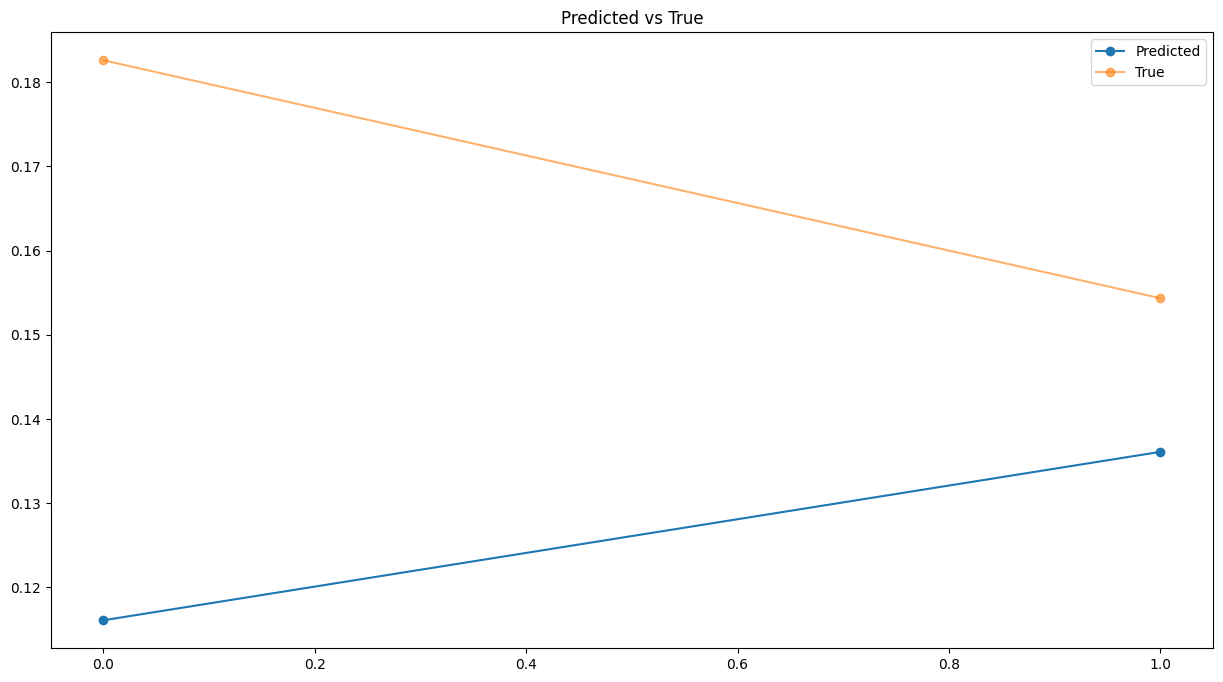

{'mae': 0.04239061021286508,
 'mse': 0.04877910328604652,
 'rmse': 0.002379400917390794}

In [40]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [41]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0              93.398796               124.0
1             102.601837               111.0

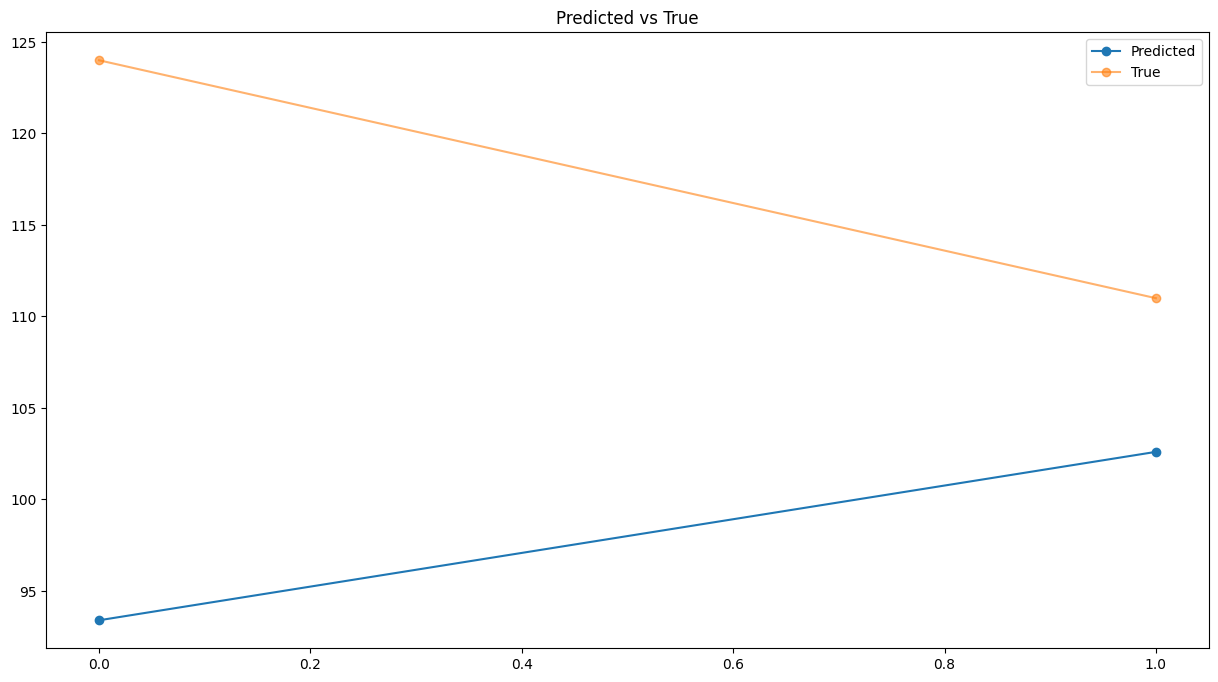

{'mae': 19.499683380126953,
 'mse': 22.438391434952816,
 'rmse': 503.48141018816386}

In [42]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Stacked LSTM con dropout

In [43]:
model = keras.models.load_model('modelos/'+paciente+'/stacked_dropout_balanceado.h5')

# Predicción de todo el conjunto de pruebas generales

In [44]:
len(array_Ytest)

191

6/6 [==============================] - 1s 12ms/step


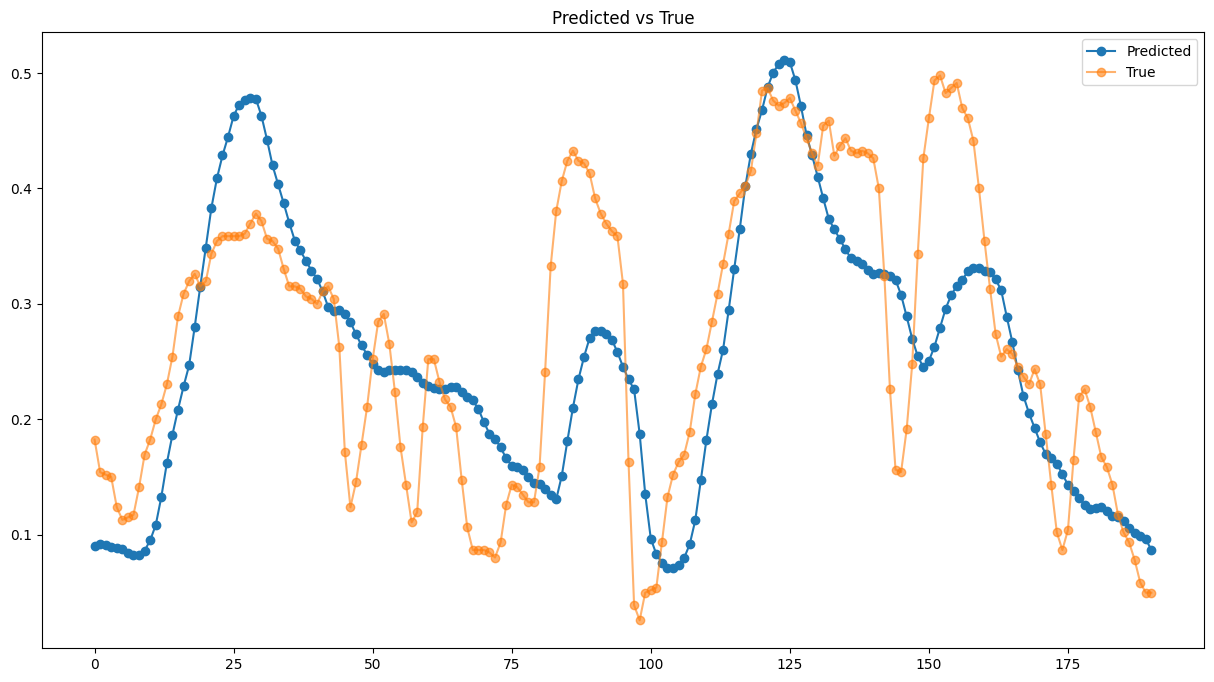

In [45]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [46]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.07188525380685014,
 'mse': 0.09057942173277984,
 'rmse': 0.008204631641444788}

In [47]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        81.742989
1        82.371216
2        81.844482
3        81.044327
4        80.741776
..             ...
186      88.823929
187      86.608284
188      85.748512
189      84.280167
190      80.014694

[191 rows x 1 columns]

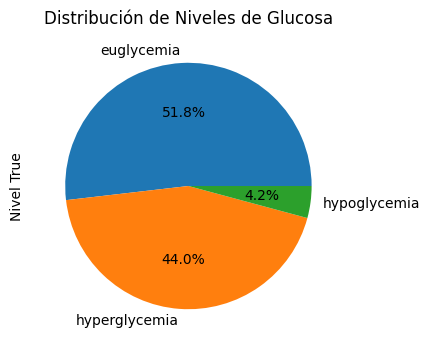

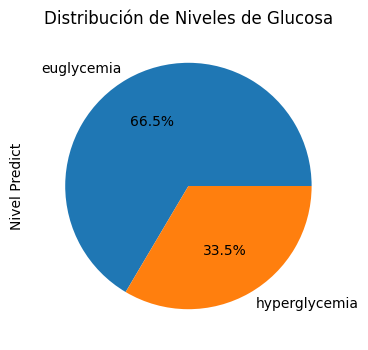

Glucose level True  Nivel True  Glucose level Predict Nivel Predict
0               124.0  euglycemia              81.742989    euglycemia
1               111.0  euglycemia              82.371216    euglycemia
2               110.0  euglycemia              81.844482    euglycemia
3               109.0  euglycemia              81.044327    euglycemia
4                97.0  euglycemia              80.741776    euglycemia

In [48]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


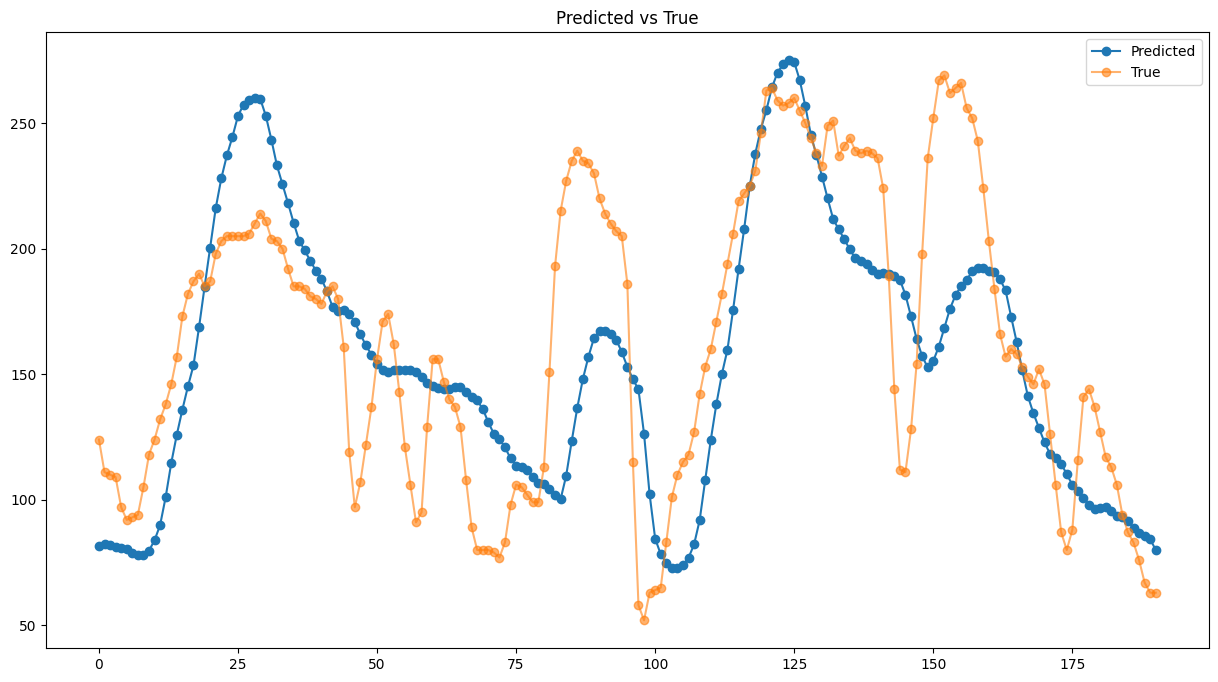

{'mae': 33.0672165236548, 'mse': 41.66653367613033, 'rmse': 1736.1000285841026}

In [49]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [50]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0            124.0
1            111.0
2            110.0
3            109.0
4             97.0
..             ...
186           83.0
187           76.0
188           67.0
189           63.0
190           63.0

[191 rows x 1 columns]

In [51]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true     y_pred
2023-01-01 00:00:00   124.0  81.742989
2023-01-01 00:15:00   111.0  82.371216
2023-01-01 00:30:00   110.0  81.844482
2023-01-01 00:45:00   109.0  81.044327
2023-01-01 01:00:00    97.0  80.741776
...                     ...        ...
2023-01-02 22:30:00    83.0  88.823929
2023-01-02 22:45:00    76.0  86.608284
2023-01-02 23:00:00    67.0  85.748512
2023-01-02 23:15:00    63.0  84.280167
2023-01-02 23:30:00    63.0  80.014694

[191 rows x 2 columns]

AP, BE, EP: (0.8736842105263158, 0.06315789473684211, 0.06315789473684211)


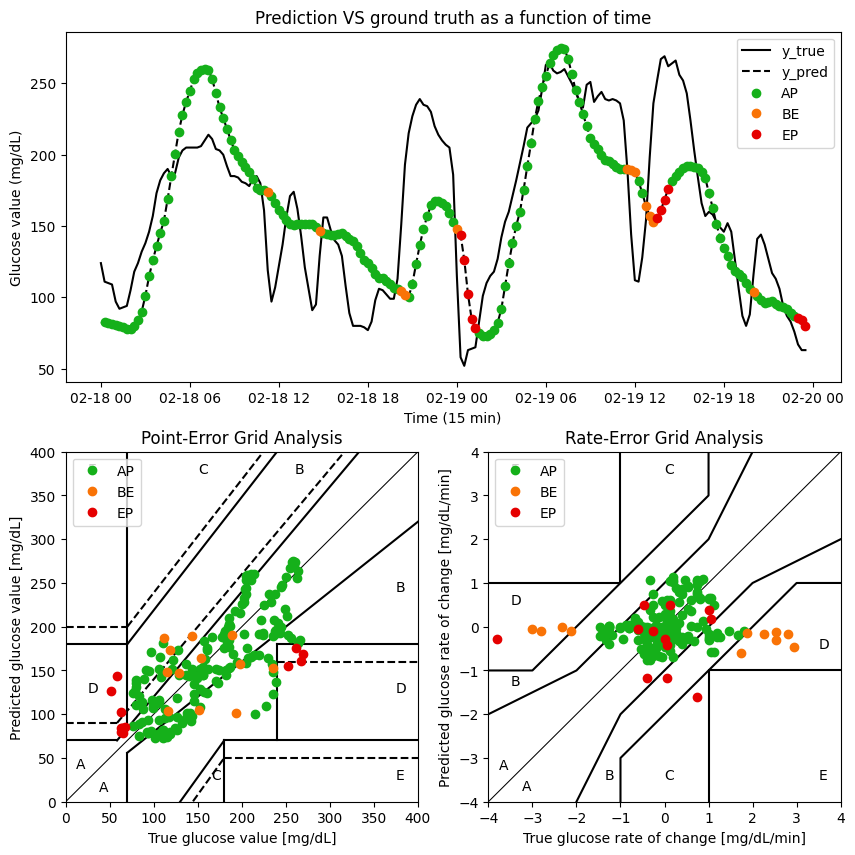

In [52]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [53]:
cg_ega.per_sample()

datetime  y_true     y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0   2023-02-18 00:00:00   124.0  81.742989       NaN       NaN    NaN   NaN   
1   2023-02-18 00:15:00   111.0  82.371216 -0.866667  0.041882     AP     B   
2   2023-02-18 00:30:00   110.0  81.844482 -0.066667 -0.035116     AP     B   
3   2023-02-18 00:45:00   109.0  81.044327 -0.066667 -0.053344     AP     B   
4   2023-02-18 01:00:00    97.0  80.741776 -0.800000 -0.020170     AP     A   
..                  ...     ...        ...       ...       ...    ...   ...   
186 2023-02-19 22:30:00    83.0  88.823929 -0.266667 -0.188527     AP     A   
187 2023-02-19 22:45:00    76.0  86.608284 -0.466667 -0.147710     AP     A   
188 2023-02-19 23:00:00    67.0  85.748512 -0.600000 -0.057318     EP     D   
189 2023-02-19 23:15:00    63.0  84.280167 -0.266667 -0.097890     EP     D   
190 2023-02-19 23:30:00    63.0  80.014694  0.000000 -0.284365     EP     D   

    R_EGA  
0     NaN  
1       A  
2       A  
3       A  
4       A  
..    ...  
186     A  
187     A  
188     A  
189     A  
190     A  

[191 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [54]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [55]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 50ms/step


Glucose level Predict  Glucose level True
0               0.090746            0.182609
1               0.092111            0.154348

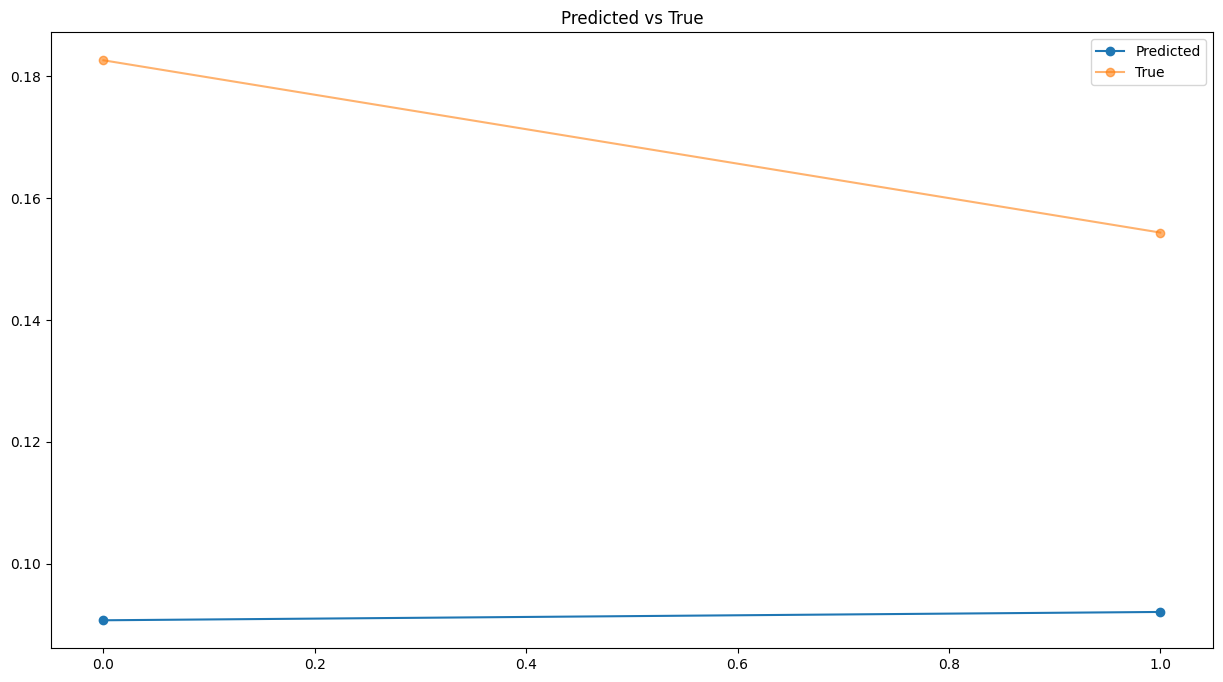

{'mae': 0.07704977610188982,
 'mse': 0.07846082849076602,
 'rmse': 0.006156101607457402}

In [56]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [57]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0              81.742989               124.0
1              82.371216               111.0

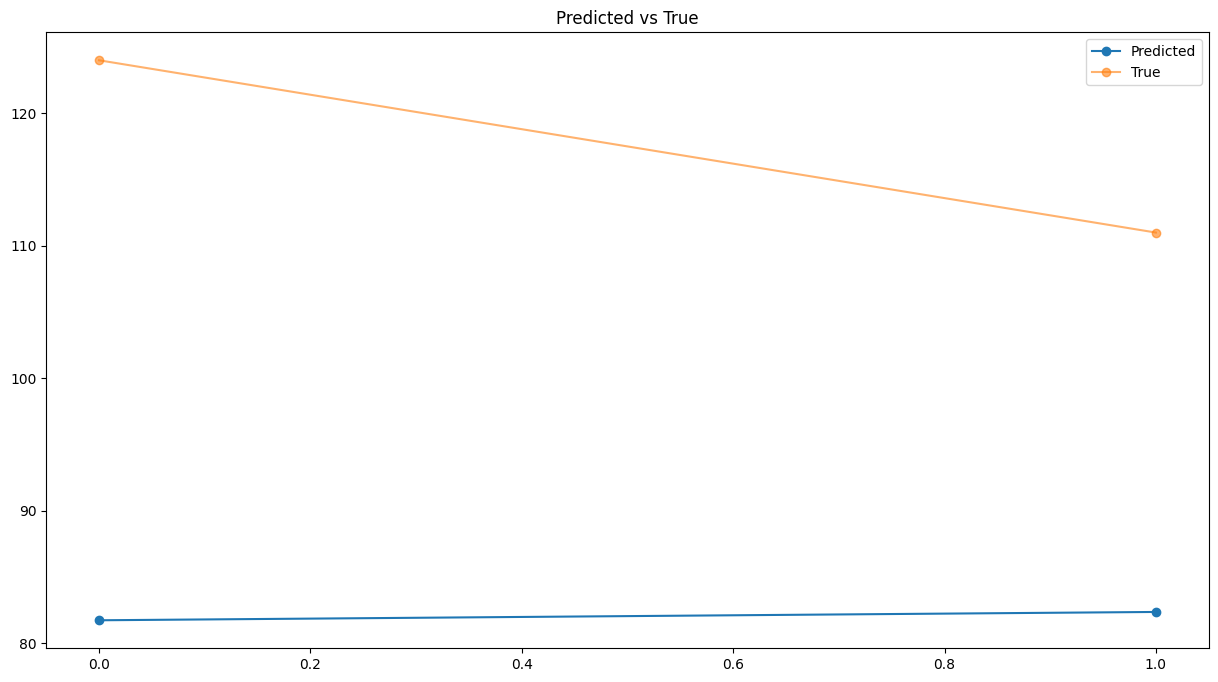

{'mae': 35.44289779663086,
 'mse': 36.09198177721796,
 'rmse': 1302.6311486070335}

In [58]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Stacked LSTM sin dropout

In [59]:
model = keras.models.load_model('modelos/'+paciente+'/stacked_NO_dropout_balanceado.h5')

# Predicción de todo el conjunto de pruebas generales

In [60]:
len(array_Ytest)

191

6/6 [==============================] - 1s 14ms/step


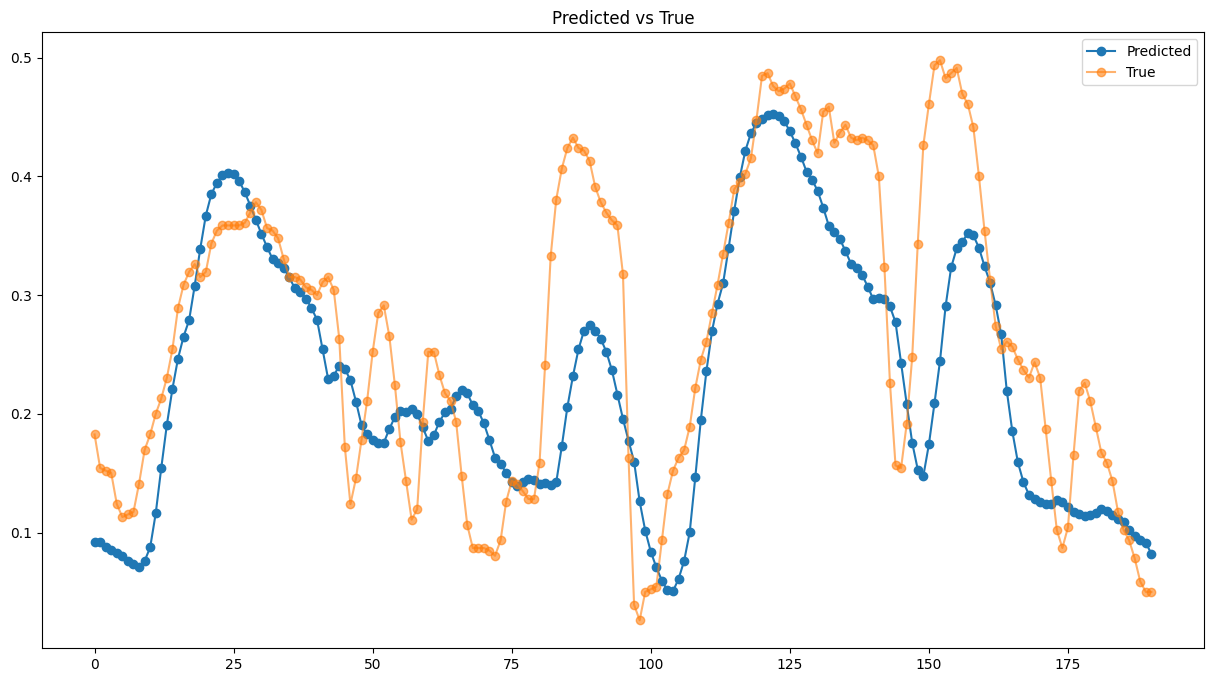

In [61]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [62]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.06790981419637186,
 'mse': 0.08897929400904382,
 'rmse': 0.007917314762347862}

In [63]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        82.407608
1        82.179733
2        80.587929
3        79.115814
4        77.981125
..             ...
186      87.072891
187      84.481674
188      83.139153
189      82.079567
190      77.719757

[191 rows x 1 columns]

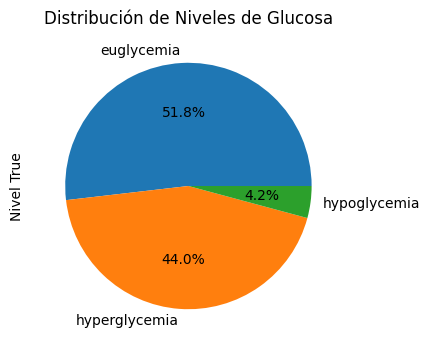

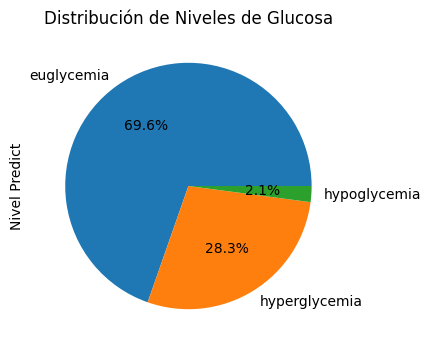

Glucose level True  Nivel True  Glucose level Predict Nivel Predict
0               124.0  euglycemia              82.407608    euglycemia
1               111.0  euglycemia              82.179733    euglycemia
2               110.0  euglycemia              80.587929    euglycemia
3               109.0  euglycemia              79.115814    euglycemia
4                97.0  euglycemia              77.981125    euglycemia

In [64]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


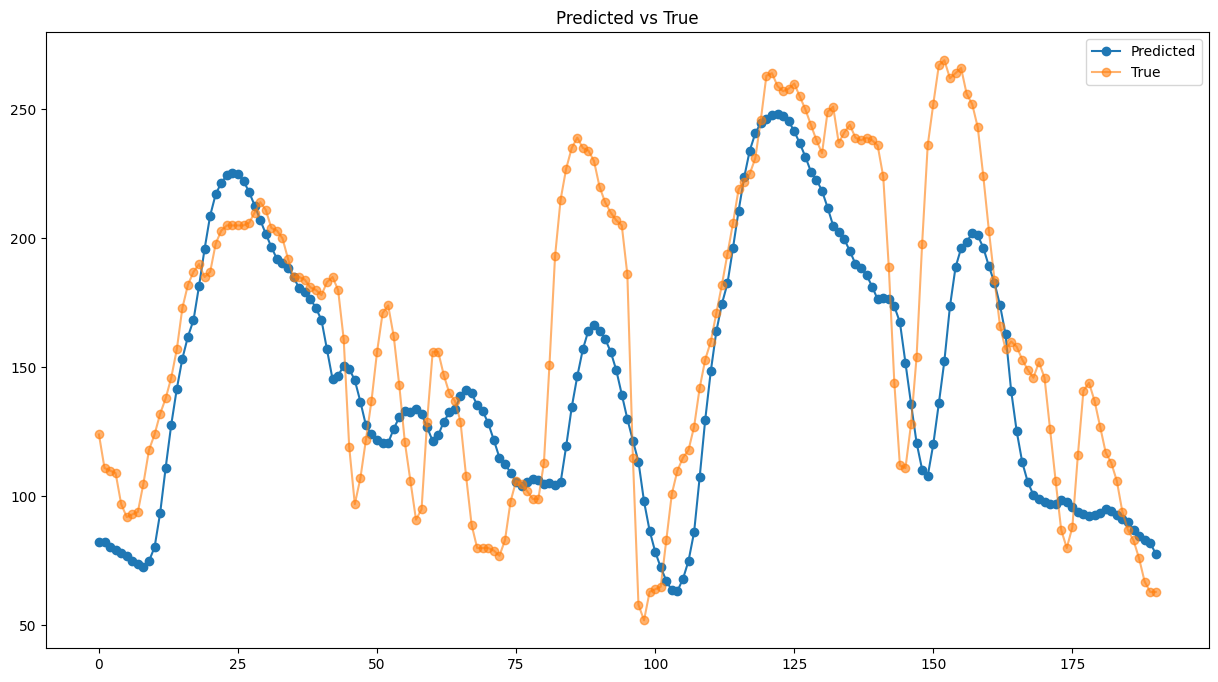

{'mae': 31.23851414625557,
 'mse': 40.930474647839716,
 'rmse': 1675.3037548974496}

In [65]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [66]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0            124.0
1            111.0
2            110.0
3            109.0
4             97.0
..             ...
186           83.0
187           76.0
188           67.0
189           63.0
190           63.0

[191 rows x 1 columns]

In [67]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true     y_pred
2023-01-01 00:00:00   124.0  82.407608
2023-01-01 00:15:00   111.0  82.179733
2023-01-01 00:30:00   110.0  80.587929
2023-01-01 00:45:00   109.0  79.115814
2023-01-01 01:00:00    97.0  77.981125
...                     ...        ...
2023-01-02 22:30:00    83.0  87.072891
2023-01-02 22:45:00    76.0  84.481674
2023-01-02 23:00:00    67.0  83.139153
2023-01-02 23:15:00    63.0  82.079567
2023-01-02 23:30:00    63.0  77.719757

[191 rows x 2 columns]

AP, BE, EP: (0.8736842105263158, 0.05789473684210526, 0.06842105263157895)


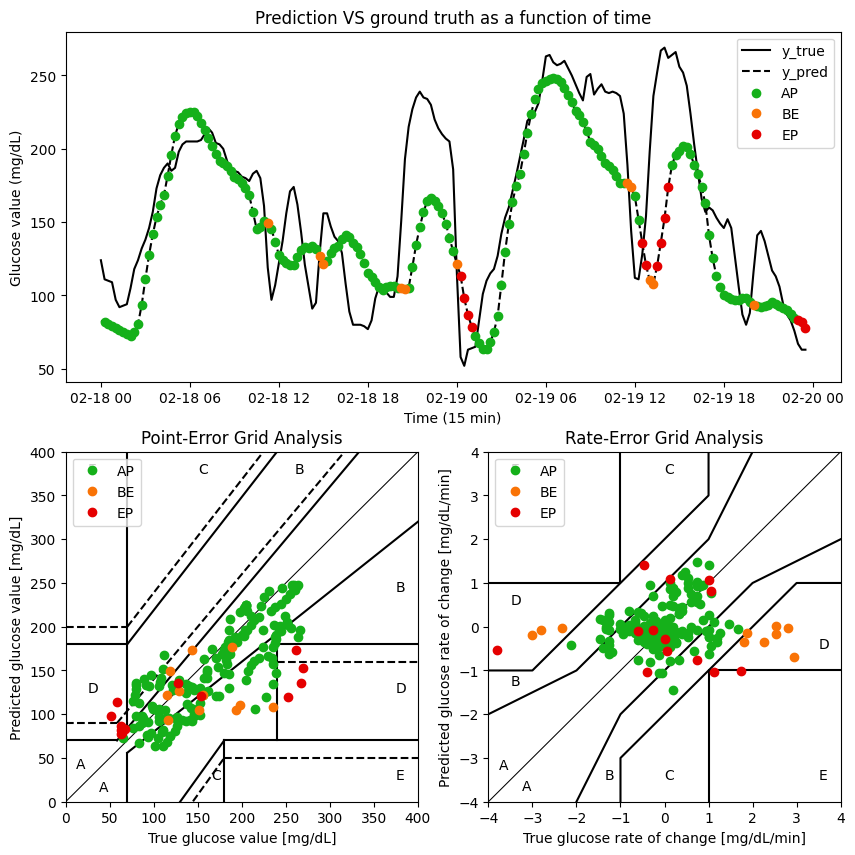

In [68]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [69]:
cg_ega.per_sample()

datetime  y_true     y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0   2023-02-18 00:00:00   124.0  82.407608       NaN       NaN    NaN   NaN   
1   2023-02-18 00:15:00   111.0  82.179733 -0.866667 -0.015192     AP     B   
2   2023-02-18 00:30:00   110.0  80.587929 -0.066667 -0.106120     AP     B   
3   2023-02-18 00:45:00   109.0  79.115814 -0.066667 -0.098141     AP     B   
4   2023-02-18 01:00:00    97.0  77.981125 -0.800000 -0.075646     AP     A   
..                  ...     ...        ...       ...       ...    ...   ...   
186 2023-02-19 22:30:00    83.0  87.072891 -0.266667 -0.193507     AP     A   
187 2023-02-19 22:45:00    76.0  84.481674 -0.466667 -0.172748     AP     A   
188 2023-02-19 23:00:00    67.0  83.139153 -0.600000 -0.089501     EP     D   
189 2023-02-19 23:15:00    63.0  82.079567 -0.266667 -0.070639     EP     D   
190 2023-02-19 23:30:00    63.0  77.719757  0.000000 -0.290654     EP     D   

    R_EGA  
0     NaN  
1       A  
2       A  
3       A  
4       A  
..    ...  
186     A  
187     A  
188     A  
189     A  
190     A  

[191 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [70]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [71]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 34ms/step


Glucose level Predict  Glucose level True
0               0.092190            0.182609
1               0.091695            0.154348

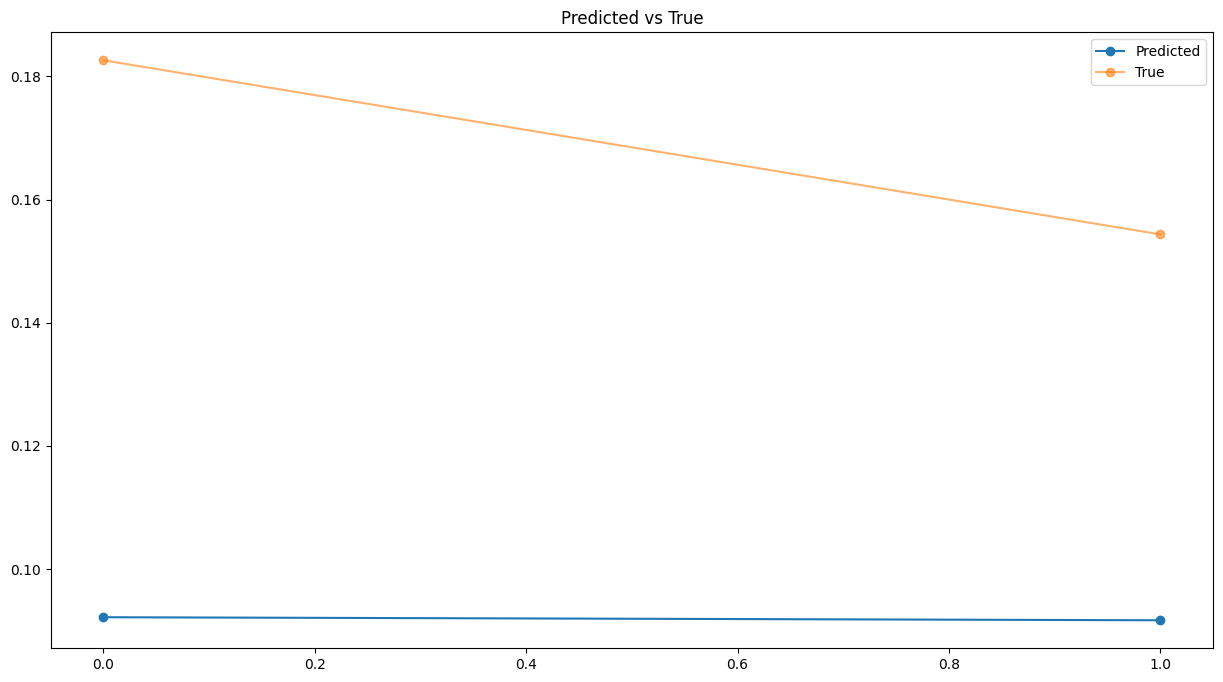

{'mae': 0.07653548487502596,
 'mse': 0.07778438672338403,
 'rmse': 0.006050410817932962}

In [72]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [73]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0              82.407616               124.0
1              82.179733               111.0

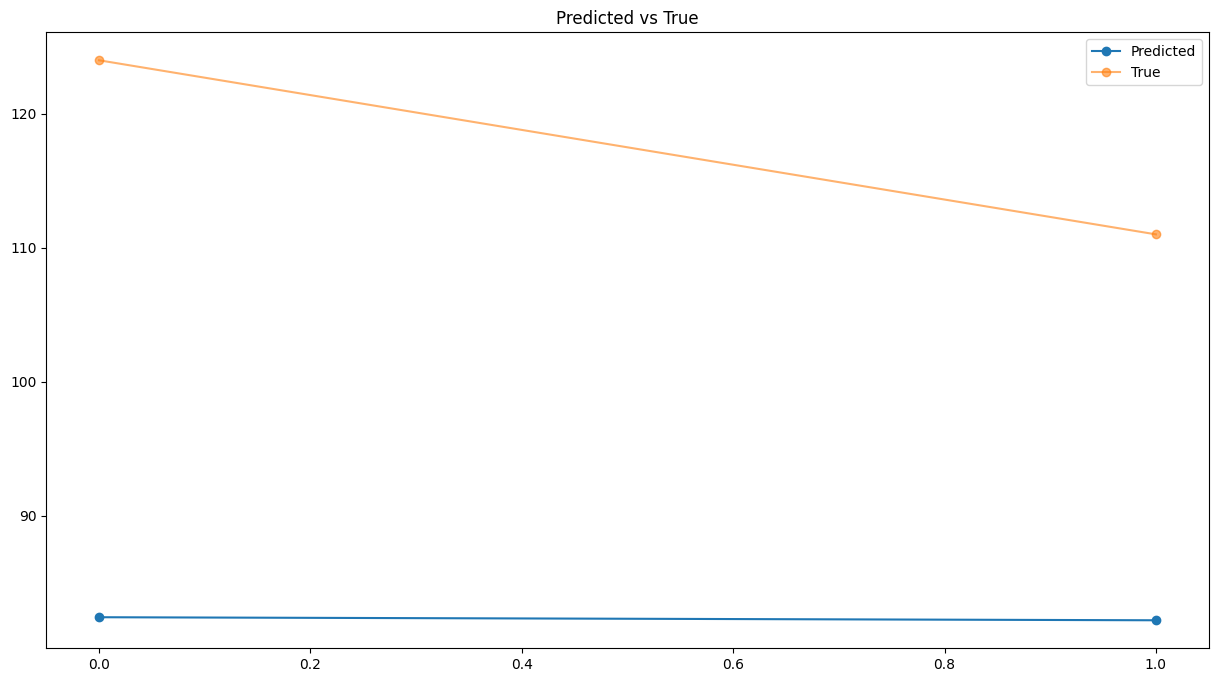

{'mae': 35.20632553100586,
 'mse': 35.78082034395497,
 'rmse': 1280.2671044863819}

In [74]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Bidirectional LSTM con dropout

In [75]:
model = keras.models.load_model('modelos/'+paciente+'/bidirectional_dropout_balanceado.h5')

# Predicción de todo el conjunto de pruebas generales

In [76]:
len(array_Ytest)

191

6/6 [==============================] - 1s 10ms/step


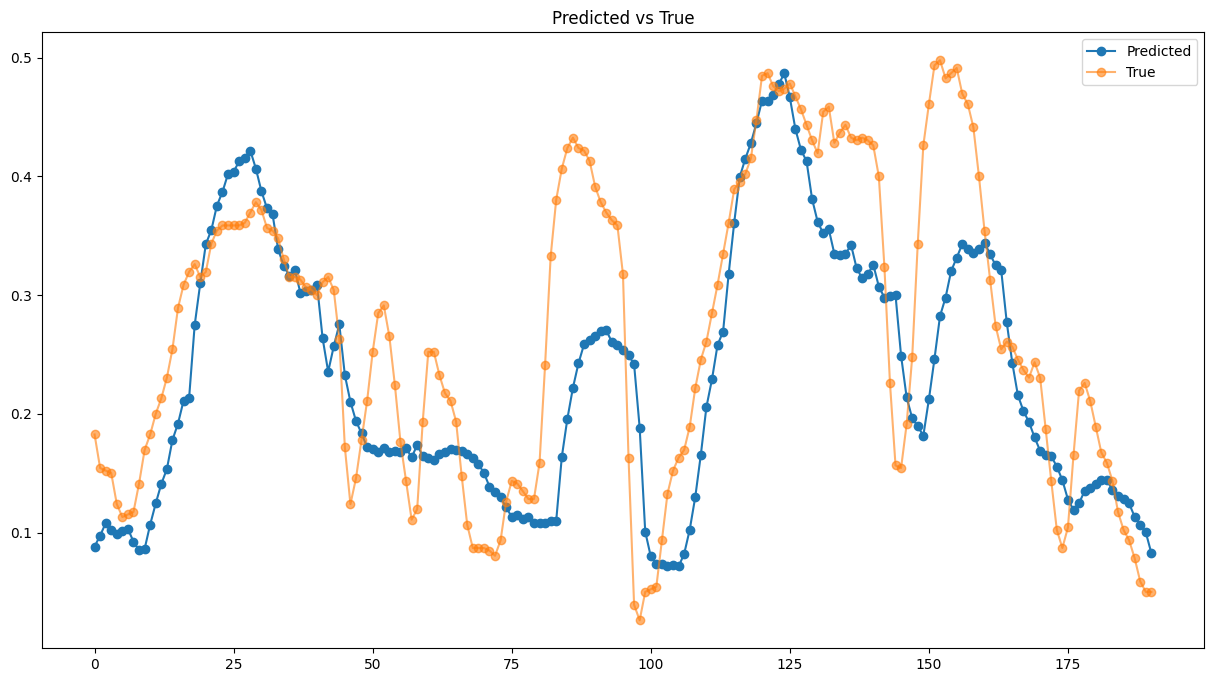

In [77]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [78]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.06618549809514486,
 'mse': 0.08692526707366854,
 'rmse': 0.007556002055828606}

In [79]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        80.575478
1        84.812706
2        89.627090
3        87.132591
4        85.328644
..             ...
186      97.255569
187      92.069412
188      88.932526
189      86.036667
190      77.969635

[191 rows x 1 columns]

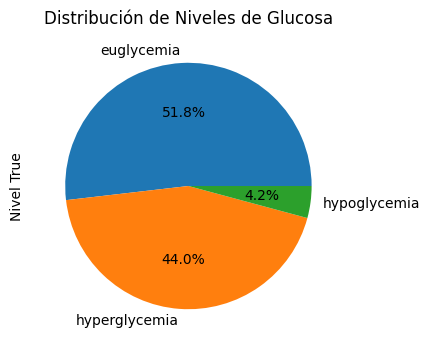

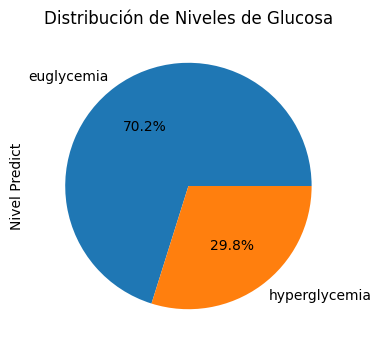

Glucose level True  Nivel True  Glucose level Predict Nivel Predict
0               124.0  euglycemia              80.575478    euglycemia
1               111.0  euglycemia              84.812706    euglycemia
2               110.0  euglycemia              89.627090    euglycemia
3               109.0  euglycemia              87.132591    euglycemia
4                97.0  euglycemia              85.328644    euglycemia

In [80]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


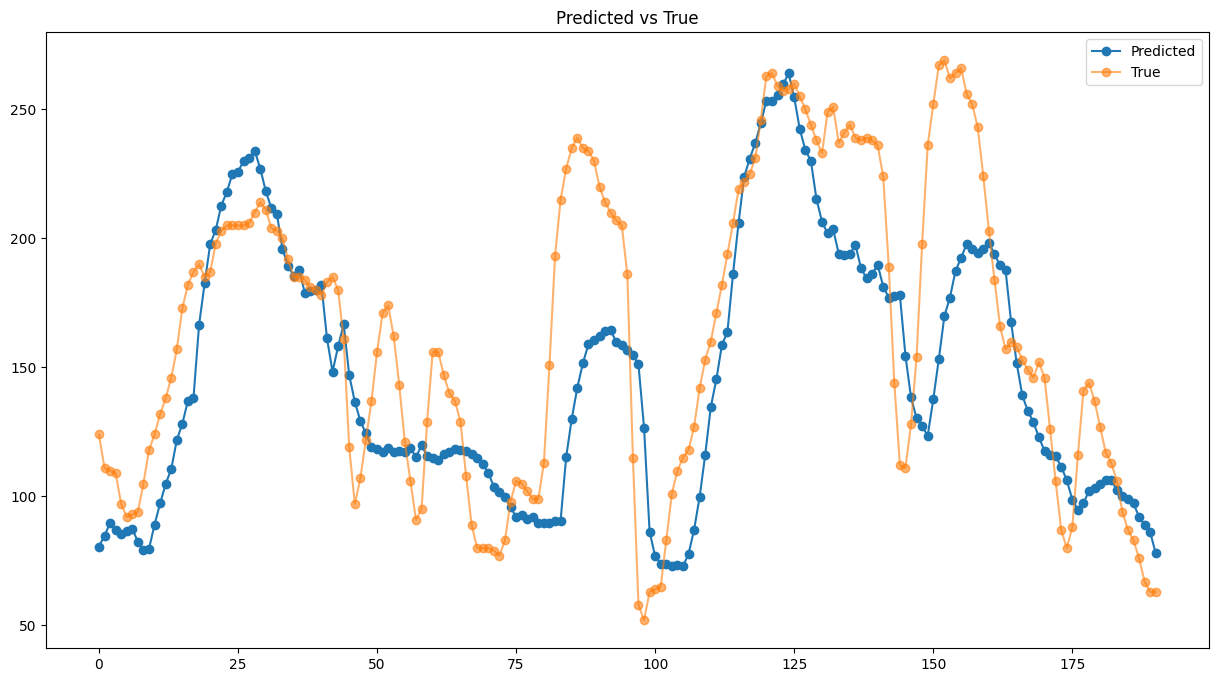

{'mae': 30.445328797345386,
 'mse': 39.98562210743322,
 'rmse': 1598.8499753184524}

In [81]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [82]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0            124.0
1            111.0
2            110.0
3            109.0
4             97.0
..             ...
186           83.0
187           76.0
188           67.0
189           63.0
190           63.0

[191 rows x 1 columns]

In [83]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true     y_pred
2023-01-01 00:00:00   124.0  80.575478
2023-01-01 00:15:00   111.0  84.812706
2023-01-01 00:30:00   110.0  89.627090
2023-01-01 00:45:00   109.0  87.132591
2023-01-01 01:00:00    97.0  85.328644
...                     ...        ...
2023-01-02 22:30:00    83.0  97.255569
2023-01-02 22:45:00    76.0  92.069412
2023-01-02 23:00:00    67.0  88.932526
2023-01-02 23:15:00    63.0  86.036667
2023-01-02 23:30:00    63.0  77.969635

[191 rows x 2 columns]

AP, BE, EP: (0.8842105263157894, 0.05789473684210526, 0.05789473684210526)


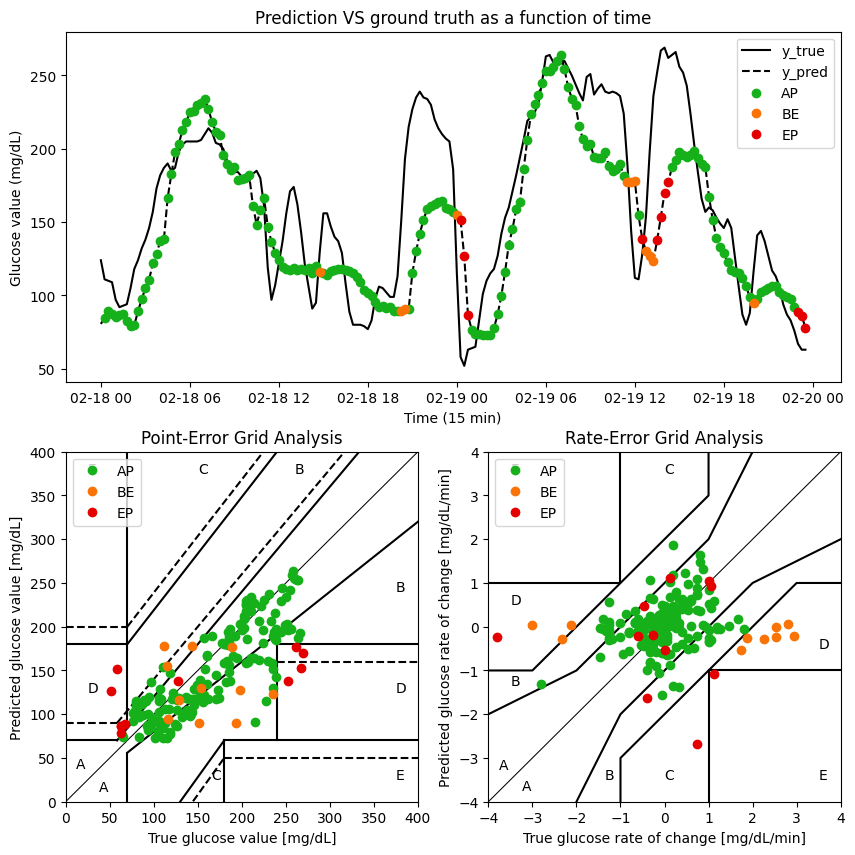

In [84]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [85]:
cg_ega.per_sample()

datetime  y_true     y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0   2023-02-18 00:00:00   124.0  80.575478       NaN       NaN    NaN   NaN   
1   2023-02-18 00:15:00   111.0  84.812706 -0.866667  0.282482     AP     B   
2   2023-02-18 00:30:00   110.0  89.627090 -0.066667  0.320959     AP     A   
3   2023-02-18 00:45:00   109.0  87.132591 -0.066667 -0.166300     AP     B   
4   2023-02-18 01:00:00    97.0  85.328644 -0.800000 -0.120263     AP     A   
..                  ...     ...        ...       ...       ...    ...   ...   
186 2023-02-19 22:30:00    83.0  97.255569 -0.266667 -0.117127     AP     A   
187 2023-02-19 22:45:00    76.0  92.069412 -0.466667 -0.345744     AP     B   
188 2023-02-19 23:00:00    67.0  88.932526 -0.600000 -0.209126     EP     D   
189 2023-02-19 23:15:00    63.0  86.036667 -0.266667 -0.193057     EP     D   
190 2023-02-19 23:30:00    63.0  77.969635  0.000000 -0.537802     EP     D   

    R_EGA  
0     NaN  
1       B  
2       A  
3       A  
4       A  
..    ...  
186     A  
187     A  
188     A  
189     A  
190     A  

[191 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [86]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [87]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 55ms/step


Glucose level Predict  Glucose level True
0               0.088208            0.182609
1               0.097419            0.154348

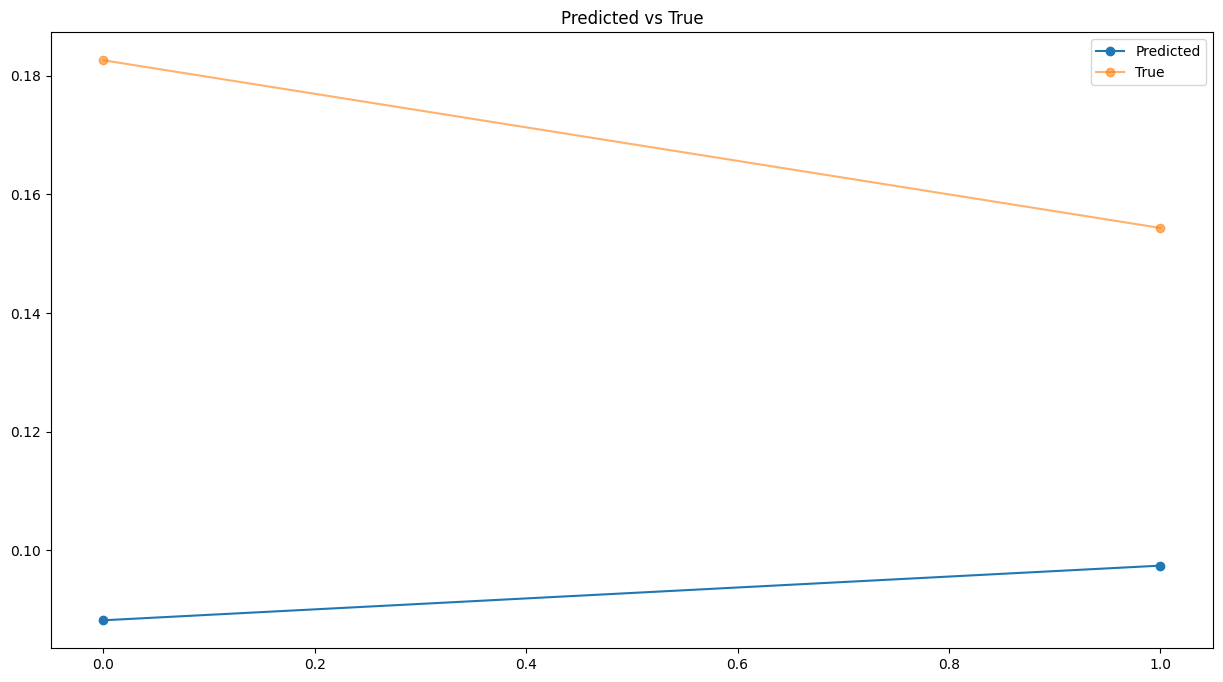

{'mae': 0.07566501864272615,
 'mse': 0.07795022442893254,
 'rmse': 0.006076237488520952}

In [88]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [89]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0              80.575478               124.0
1              84.812706               111.0

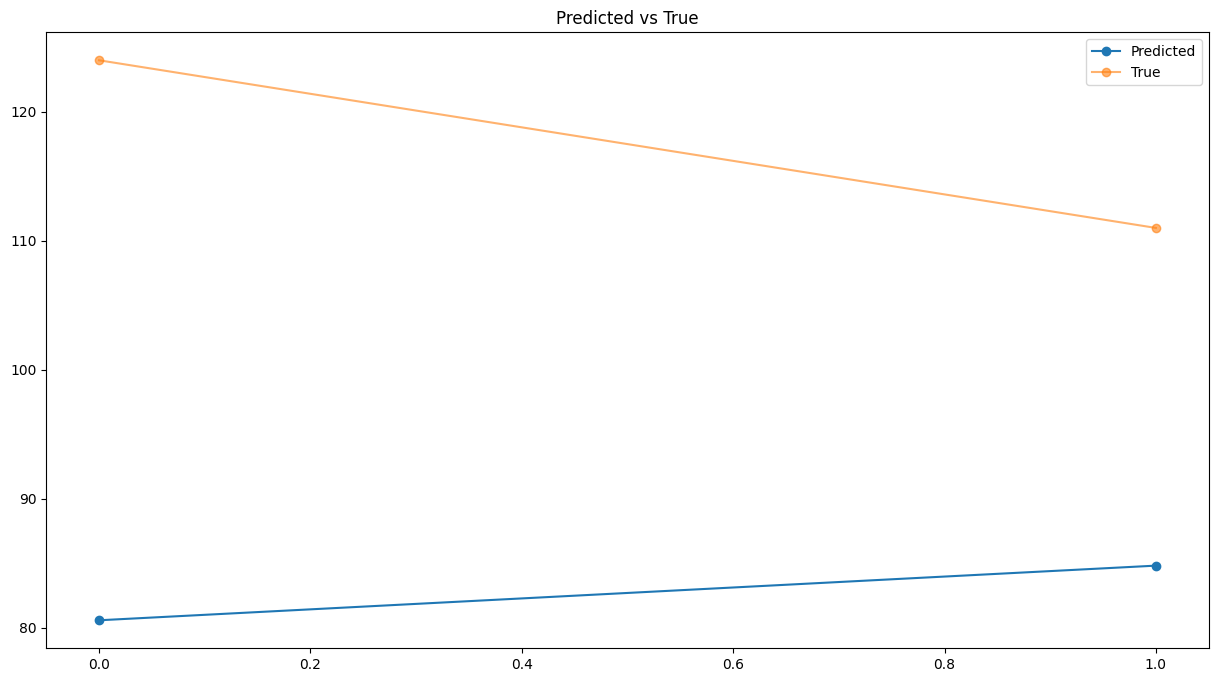

{'mae': 34.805908203125, 'mse': 35.857101897912166, 'rmse': 1285.7317565172561}

In [90]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Bidirectional LSTM sin dropout

In [91]:
model = keras.models.load_model('modelos/'+paciente+'/bidirectional_NO_dropout_balanceado.h5')

# Predicción de todo el conjunto de pruebas generales

In [92]:
len(array_Ytest)

191

6/6 [==============================] - 1s 13ms/step


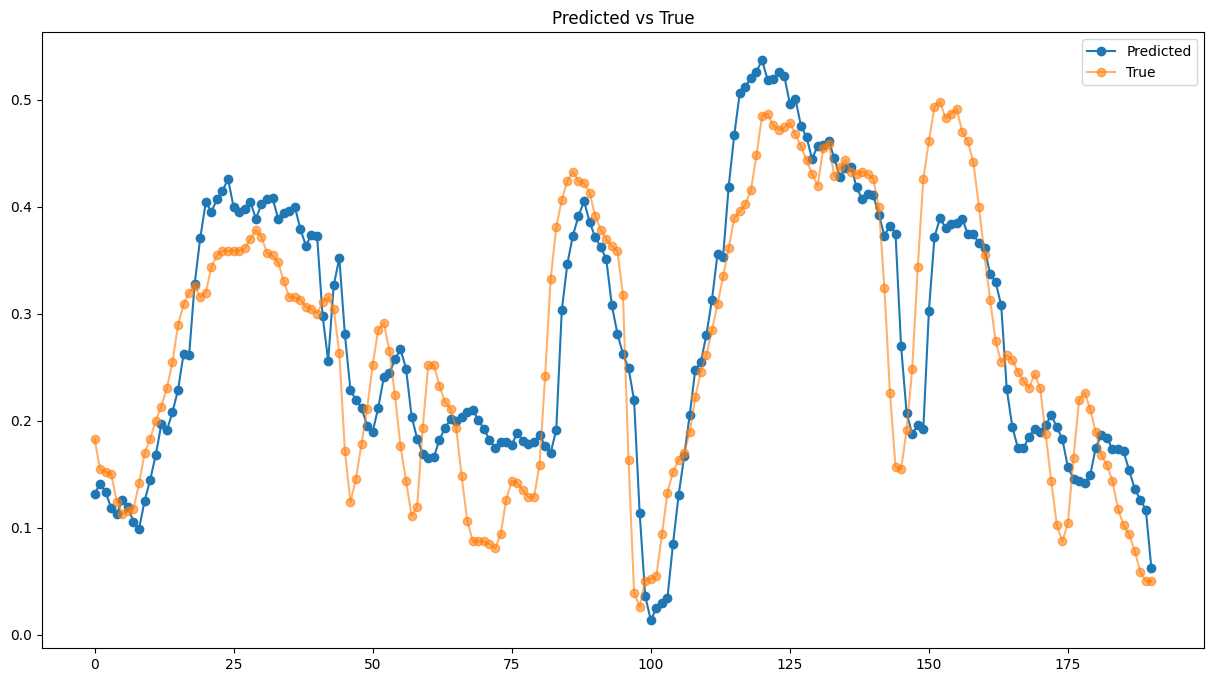

In [93]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [94]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.055735107101355874,
 'mse': 0.06882337100838147,
 'rmse': 0.004736656396957323}

In [95]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0       100.451553
1       104.803970
2       101.073730
3        94.376709
4        91.768951
..             ...
186     110.590149
187     102.682739
188      98.000450
189      93.688721
190      68.418602

[191 rows x 1 columns]

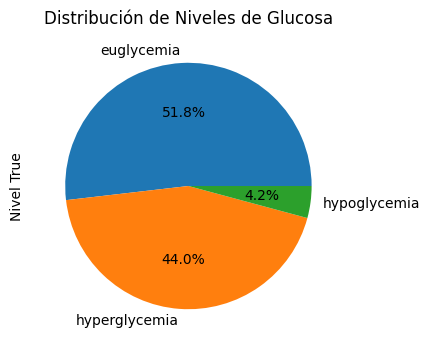

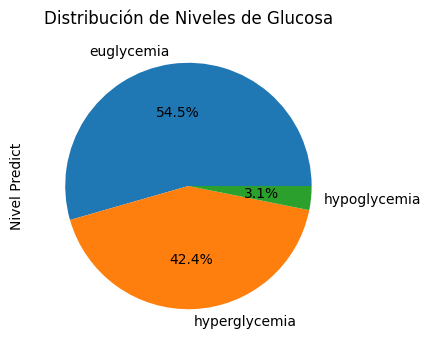

Glucose level True  Nivel True  Glucose level Predict Nivel Predict
0               124.0  euglycemia             100.451553    euglycemia
1               111.0  euglycemia             104.803970    euglycemia
2               110.0  euglycemia             101.073730    euglycemia
3               109.0  euglycemia              94.376709    euglycemia
4                97.0  euglycemia              91.768951    euglycemia

In [96]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


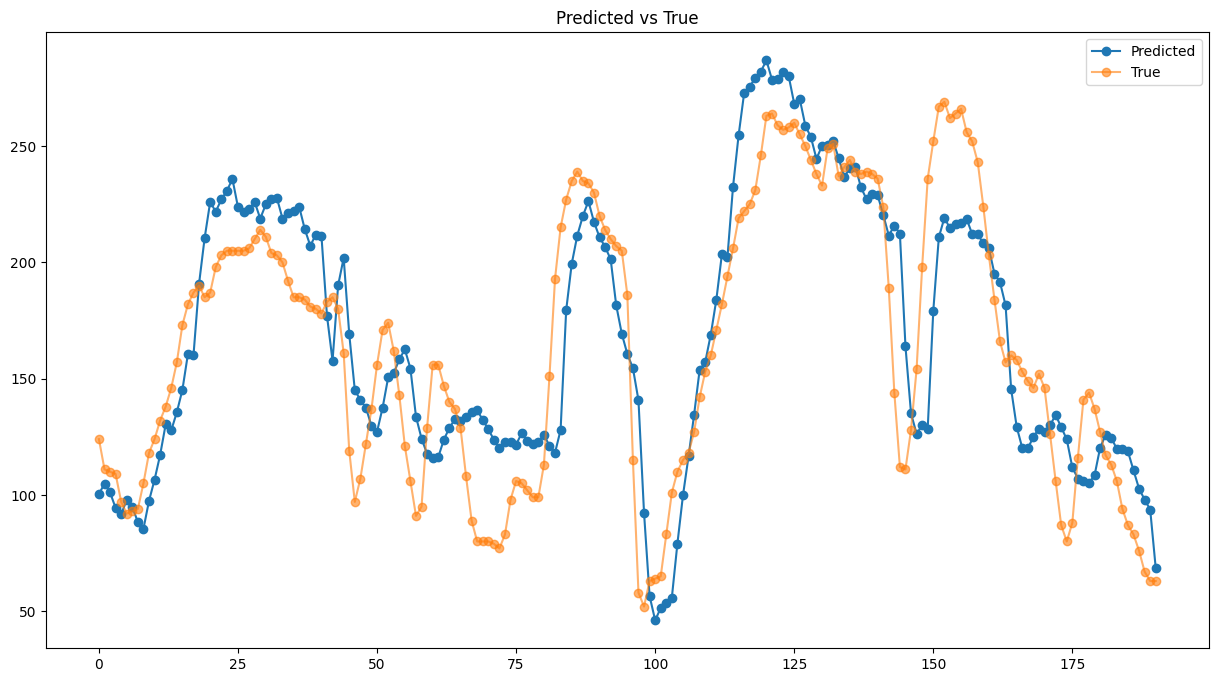

{'mae': 25.638148362723946,
 'mse': 31.658749928180715,
 'rmse': 1002.2764470150825}

In [97]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [98]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0            124.0
1            111.0
2            110.0
3            109.0
4             97.0
..             ...
186           83.0
187           76.0
188           67.0
189           63.0
190           63.0

[191 rows x 1 columns]

In [99]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   124.0  100.451553
2023-01-01 00:15:00   111.0  104.803970
2023-01-01 00:30:00   110.0  101.073730
2023-01-01 00:45:00   109.0   94.376709
2023-01-01 01:00:00    97.0   91.768951
...                     ...         ...
2023-01-02 22:30:00    83.0  110.590149
2023-01-02 22:45:00    76.0  102.682739
2023-01-02 23:00:00    67.0   98.000450
2023-01-02 23:15:00    63.0   93.688721
2023-01-02 23:30:00    63.0   68.418602

[191 rows x 2 columns]

AP, BE, EP: (0.8894736842105263, 0.08421052631578947, 0.02631578947368421)


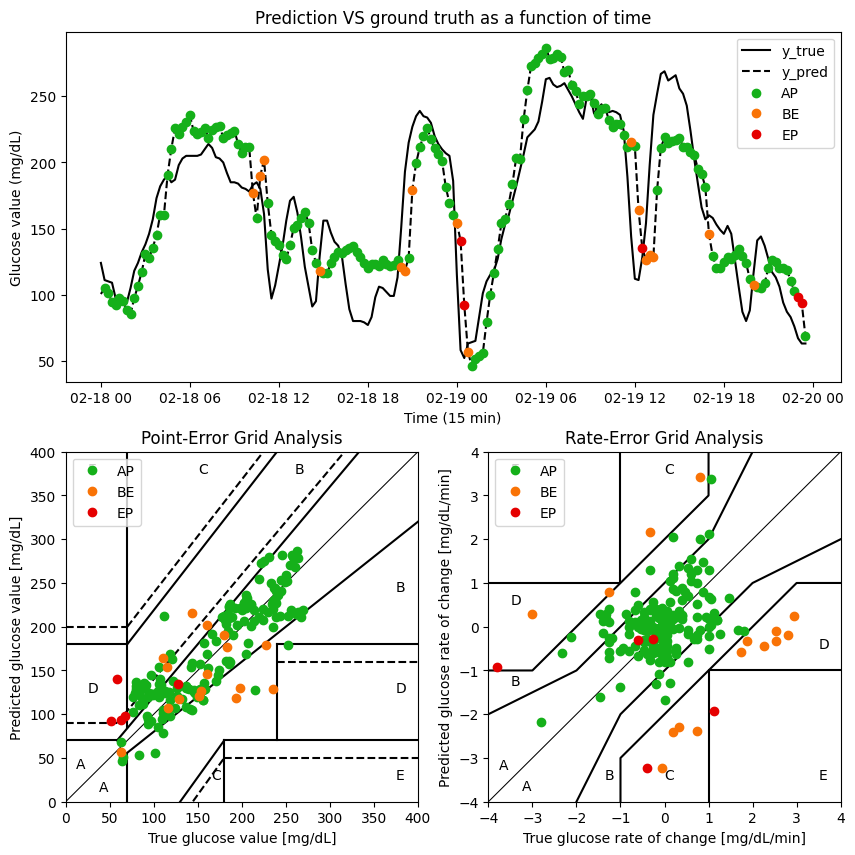

In [100]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [101]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0   2023-02-18 00:00:00   124.0  100.451553       NaN       NaN    NaN   NaN   
1   2023-02-18 00:15:00   111.0  104.803970 -0.866667  0.290161     AP     A   
2   2023-02-18 00:30:00   110.0  101.073730 -0.066667 -0.248683     AP     A   
3   2023-02-18 00:45:00   109.0   94.376709 -0.066667 -0.446468     AP     A   
4   2023-02-18 01:00:00    97.0   91.768951 -0.800000 -0.173851     AP     A   
..                  ...     ...         ...       ...       ...    ...   ...   
186 2023-02-19 22:30:00    83.0  110.590149 -0.266667 -0.541779     AP     B   
187 2023-02-19 22:45:00    76.0  102.682739 -0.466667 -0.527161     AP     B   
188 2023-02-19 23:00:00    67.0   98.000450 -0.600000 -0.312153     EP     D   
189 2023-02-19 23:15:00    63.0   93.688721 -0.266667 -0.287449     EP     D   
190 2023-02-19 23:30:00    63.0   68.418602  0.000000 -1.684675     AP     A   

    R_EGA  
0     NaN  
1       B  
2       A  
3       A  
4       A  
..    ...  
186     A  
187     A  
188     A  
189     A  
190     B  

[191 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [102]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [103]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 43ms/step


Glucose level Predict  Glucose level True
0               0.131416            0.182609
1               0.140878            0.154348

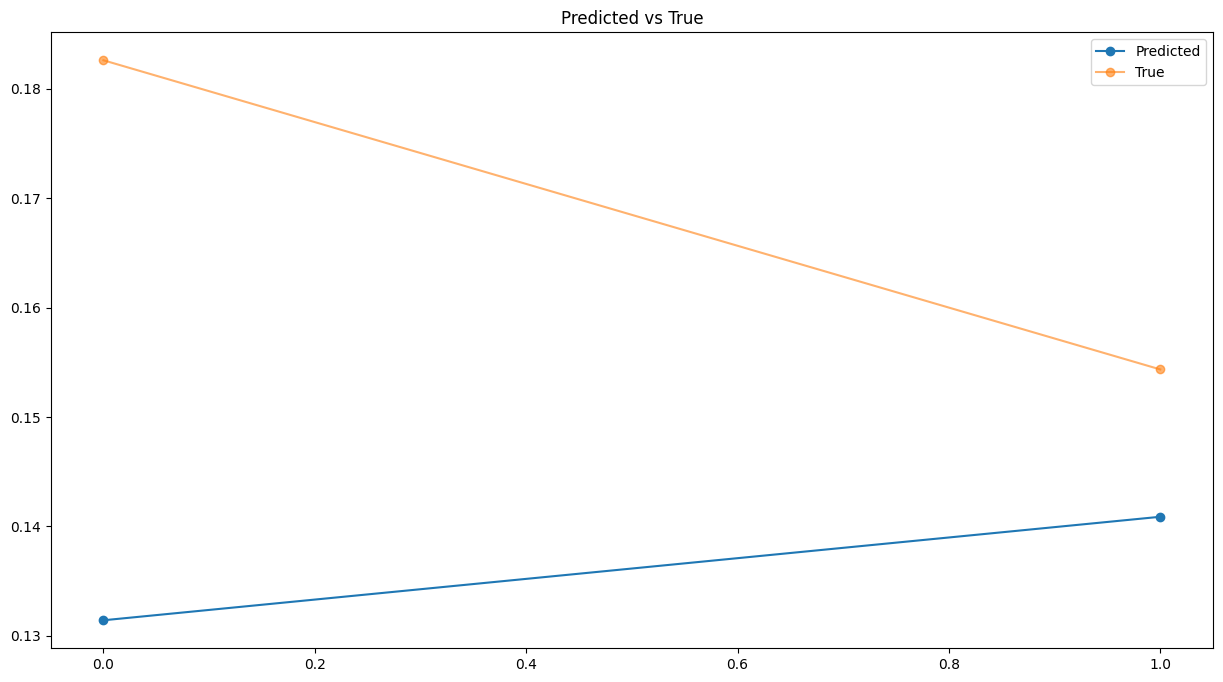

{'mae': 0.03233097785192987,
 'mse': 0.03743049044658251,
 'rmse': 0.0014010416150717047}

In [104]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [105]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             100.451538               124.0
1             104.803955               111.0

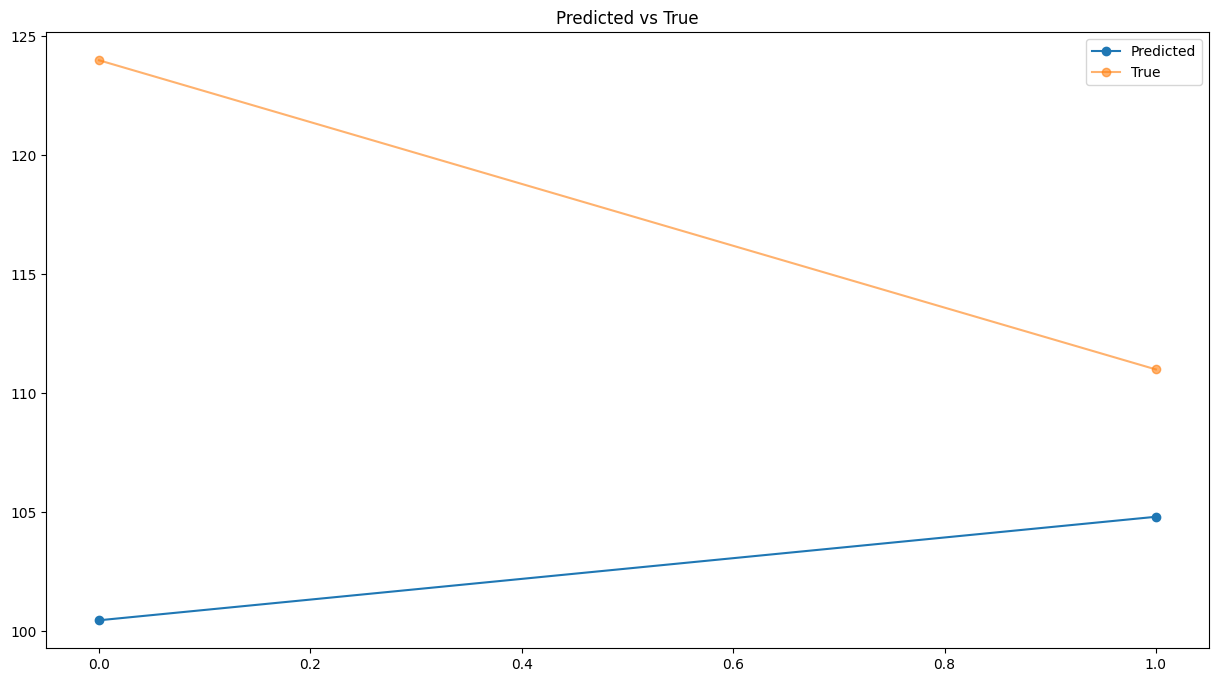

{'mae': 14.87225341796875,
 'mse': 17.218028795305592,
 'rmse': 296.46051559597254}

In [106]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)